# Random Forest in Python

## Roadmap

The following steps form the basis for any machine learning workflow once we have a problem and model in mind:

1. State the question and determine required data.
2. Acquire the data in an accessible format.
3. Identify and correct missing data points/anomalies as required.
4. Prepare the data for the machine learning model.
5. Establish a baseline model that you aim to exceed.
6. Train the model on the training data.
7. Make predictions on the test data.
8. Compare predictions to the known test set targets and calculate performance metrics.
9. If performance is not satisfactory, adjust the model, acquire more data, or try a different modeling technique.
10. Interpret model and report results visually and numerically.

## Problem Introduction
The problem we will tackle is predicting the max temperature for tomorrow in our city using one year of past weather data. We have access to is one year of historical max temperatures, the temperatures for the previous two days, and an estimate from a friend who is always claiming to know everything about the weather. This is a supervised, regression machine learning problem. 

In [28]:
import pandas as pd

# Read in data and display first 5 rows
features = pd.read_csv('temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [29]:
print('The shape of our features is:', features.shape)

The shape of our features is: (348, 12)


To identify anomalies, we can quickly compute summary statistics:

In [30]:
features.describe()# Descriptive statistics for each column

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


### Plotting Graph To Check Anomalies

In [31]:

from ydata_profiling import ProfileReport
import datetime
profile = ProfileReport(features, title="Pandas Profiling Report", vars={
                        "num": {"low_categorical_threshold": 0}})



# Get years, months, and days
years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

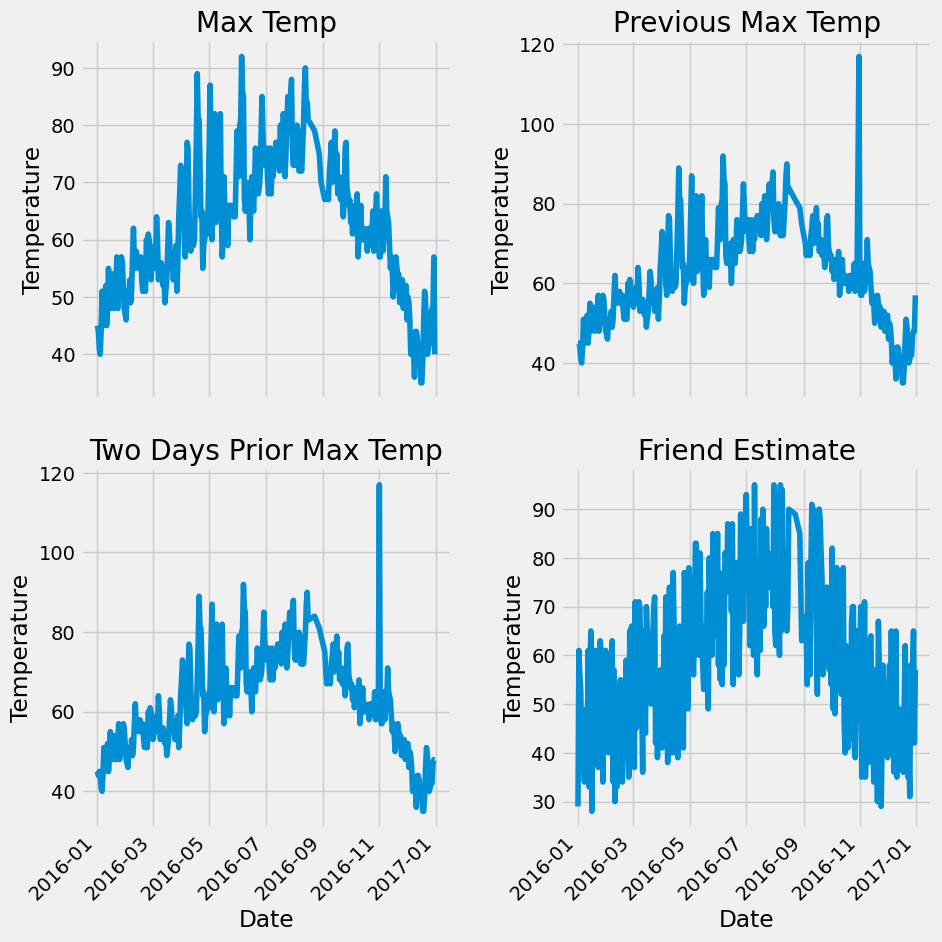

In [32]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

## Data Prepeation

We will use the Python library Pandas for our data manipulation relying, on the structure known as a dataframe, which is basically an excel spreadsheet with rows and columns.

### One-Hot Encoding

The first step for us is known as one-hot encoding of the data. This process takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering.

What computers know is numbers and for machine learning we must accommodate them. We could simply map days of the week to numbers 1–7, but this might lead to the algorithm placing more importance on Sunday because it has a higher numerical value. Instead, we change the single column of weekdays into seven columns of binary data.

In [12]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(features)

# Display the first 5 rows of the last 12 columns
features.iloc[:, 5:].head(5)

,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,45.6,45,43,50,44,29,True,False,False,False,False,False,False
1,45.7,44,41,50,44,61,False,False,True,False,False,False,False
2,45.8,41,43,46,47,56,False,False,False,True,False,False,False
3,45.9,40,44,48,46,53,False,True,False,False,False,False,False
4,46.0,44,46,46,46,41,False,False,False,False,False,True,False


### Features and Targets and Convert Data to Arrays

Now, we need to separate the data into the features and targets. The target, also known as the label, is the value we want to predict, in this case the actual max temperature and the features are all the columns the model uses to make a prediction. 

In [13]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['actual'])

# Removing the labels from the features
# axis 1 refers to the columns
features = features.drop('actual', axis=1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

### Training and Testing Sets

In [14]:
# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)

In [15]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


## Establish Baseline
Before we can make and evaluate predictions, we need to establish a baseline, a sensible measure that we hope to beat with our model. If our model cannot improve upon the baseline, then it will be a failure and we should try a different model or admit that machine learning is not right for our problem.<br>

The baseline prediction for our case can be the historical max temperature averages. In other words, our baseline is the error we would get if we simply predicted the average max temperature for all days.

In [16]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  5.06


## Train Model

In [17]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

## Make Predictions on the Test Set

In [18]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.87 degrees.


## Determine Performance Metrics

To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100%.

In [19]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.93 %.


## Interpret Model Results

### Visualizing a Single Decision Tree


The following code takes one tree from the forest and saves it as an image.

In [33]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file='tree.dot',feature_names=feature_list, rounded=True, precision=1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

FileNotFoundError: [Errno 2] "dot" not found in path.

In [34]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 13


**Smaller tree for visualization**

In [35]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file='small_tree.dot',
                feature_names=feature_list, rounded=True, precision=1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png')

FileNotFoundError: [Errno 2] "dot" not found in path.

### Variable Importances
In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. 

In [36]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair))
 for pair in feature_importances]

Variable: temp_1               Importance: 0.66
Variable: average              Importance: 0.15
Variable: forecast_noaa        Importance: 0.05
Variable: forecast_acc         Importance: 0.03
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_under       Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Let’s quickly make a random forest with only the two most important variables, the max temperature 1 day prior and the historical average and see how the performance compares.

In [37]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators=1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.76 %.


## Visualisations

### Variable Importances


Text(0.5, 1.0, 'Variable Importances')

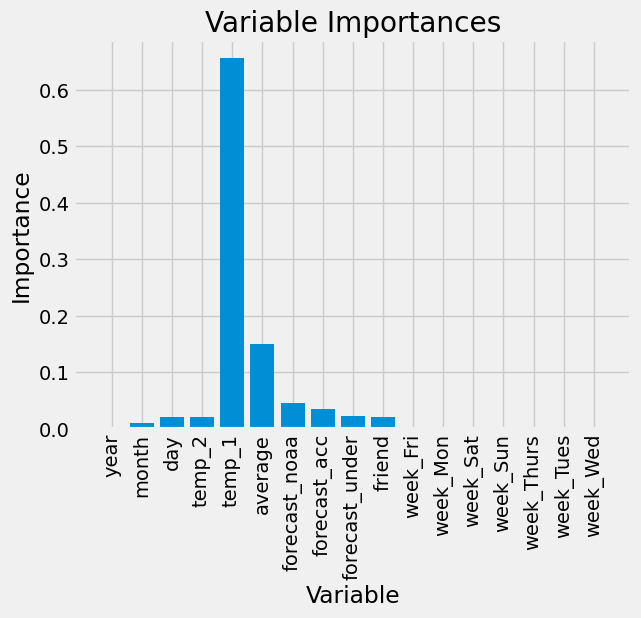

In [38]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation='vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

### Predictions and Actual Values

> Plotting the entire dataset with predictions highlighted.

In [43]:
from sklearn.impute import SimpleImputer
# Dates of training values
months = features.iloc[:, feature_list.index('month')]
days = features.iloc[:, feature_list.index('day')]
years = features.iloc[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data={'date': dates, 'actual': labels})

# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data={'date': test_dates, 'prediction': predictions})

Text(0.5, 1.0, 'Actual and Predicted Values')

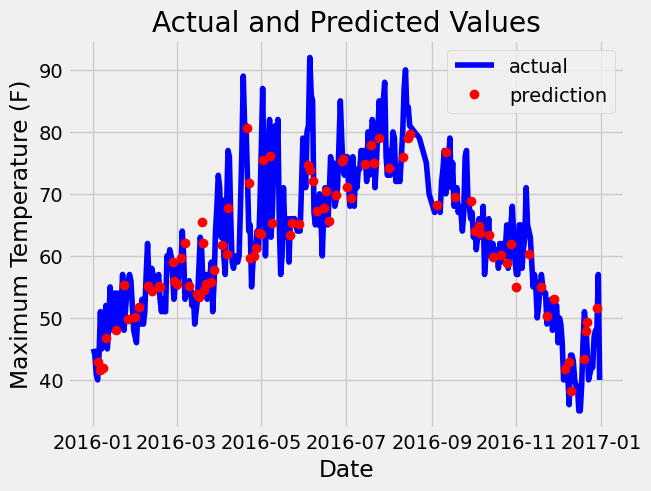

In [46]:
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')

# Plot the predicted values
plt.plot(predictions_data['date'],predictions_data['prediction'], 'ro', label='prediction')
plt.xticks(rotation='horizontal')
plt.legend()

# Graph labels
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')
plt.title('Actual and Predicted Values')

### Targets and Data Visualization


Text(0.5, 1.0, 'Actual Max Temp and Variables')

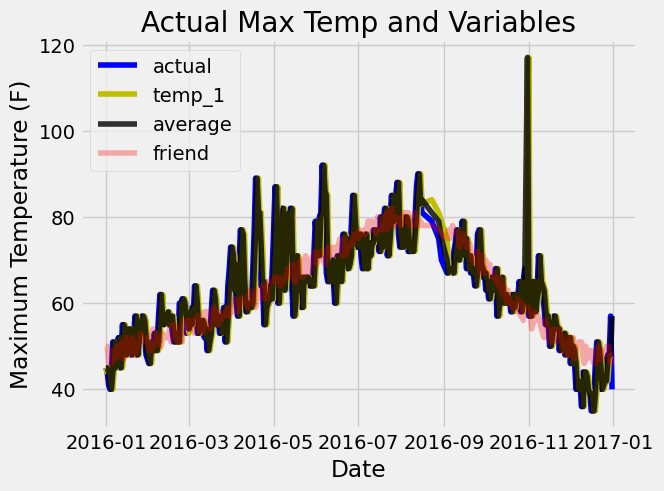

In [50]:
# Make the data accessible for plotting
true_data['temp_1'] = features.iloc[:, feature_list.index('temp_1')]
true_data['average'] = features.iloc[:, feature_list.index('average')]
true_data['friend'] = features.iloc[:, feature_list.index('friend')]

# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'],'b-', label='actual', alpha=1.0)
plt.plot(true_data['date'], true_data['temp_1'],'y-', label='temp_1', alpha=1.0)
plt.plot(true_data['date'], true_data['average'],'k-', label='average', alpha=0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label='friend', alpha=0.3)

# Formatting plot
plt.legend()
plt.xticks(rotation='horizontal')

# Lables and title
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')
plt.title('Actual Max Temp and Variables')